In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xar

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [2]:
# Get the Waste training and validation dataset
!wget -q -P /content/ https://storage.googleapis.com/scum-recycle-storage/DATASET.zip

dataset_local_zip = './DATASET.zip'
zip_ref = zipfile.ZipFile(dataset_local_zip, 'r')
zip_ref.extractall('/tmp')

zip_ref.close()

In [3]:
train_dir = '/tmp/DATASET/TRAIN'
validation_dir = '/tmp/DATASET/TEST'

# Directory with training alucan pictures
train_alucan_dir = os.path.join(train_dir, 'AluCan')

# Directory with training glass pictures
train_glass_dir = os.path.join(train_dir, 'Glass')

# Directory with training pet pictures
train_pet_dir = os.path.join(train_dir, 'PET')

# Directory with validation alucan pictures
validation_alucan_dir = os.path.join(validation_dir, 'AluCan')

# Directory with validation glass pictures
validation_glass_dir = os.path.join(validation_dir, 'Glass')

# Directory with validation pet pictures
validation_pet_dir = os.path.join(validation_dir, 'PET')

print('total training alucan images:', len(os.listdir(train_alucan_dir)))
print('total training glass images:', len(os.listdir(train_glass_dir)))
print('total training pet images:', len(os.listdir(train_pet_dir)))
print('total validation alucan images:', len(os.listdir(validation_alucan_dir)))
print('total validation glass images:', len(os.listdir(validation_glass_dir)))
print('total validation pet images:', len(os.listdir(validation_pet_dir)))

total training alucan images: 800
total training glass images: 800
total training pet images: 800
total validation alucan images: 200
total validation glass images: 200
total validation pet images: 200


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,               # This is the source directory for training images
                                                    target_size=(150, 150),  # All images will be resized to 150x150
                                                    shuffle=True,
                                                    class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255.)

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(150, 150),
                                                              shuffle=True,
                                                              class_mode='categorical')

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [5]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-05-29 08:33:20--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 142.251.172.128, 209.85.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   110MB/s    in 0.8s    

2023-05-29 08:33:21 (110 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [6]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [7]:
# loading in the Inception v3 model
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False, 
                                weights=local_weights_file) 

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable=False

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
last_desired_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_desired_layer.output_shape)
last_output = last_desired_layer.output
print('last layer output: ', last_output)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 128 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)  
# Add a final softmax layer for multiclass classification
x = layers.Dense(3, activation='softmax')(x)        

# Create the complete model by using the Model class
model = Model(inputs=pre_trained_model.input, outputs=x)

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    verbose=2)

Epoch 1/20
75/75 - 55s - loss: 0.7847 - accuracy: 0.6521 - val_loss: 0.5211 - val_accuracy: 0.7600 - 55s/epoch - 732ms/step
Epoch 2/20
75/75 - 36s - loss: 0.4860 - accuracy: 0.8142 - val_loss: 0.4531 - val_accuracy: 0.7900 - 36s/epoch - 479ms/step
Epoch 3/20
75/75 - 40s - loss: 0.3989 - accuracy: 0.8458 - val_loss: 0.4419 - val_accuracy: 0.8050 - 40s/epoch - 527ms/step
Epoch 4/20
75/75 - 36s - loss: 0.3444 - accuracy: 0.8721 - val_loss: 0.3060 - val_accuracy: 0.8733 - 36s/epoch - 479ms/step
Epoch 5/20
75/75 - 36s - loss: 0.2797 - accuracy: 0.8967 - val_loss: 0.3784 - val_accuracy: 0.8367 - 36s/epoch - 479ms/step
Epoch 6/20
75/75 - 39s - loss: 0.2743 - accuracy: 0.8929 - val_loss: 0.2844 - val_accuracy: 0.8917 - 39s/epoch - 521ms/step
Epoch 7/20
75/75 - 42s - loss: 0.2513 - accuracy: 0.8996 - val_loss: 0.2702 - val_accuracy: 0.8867 - 42s/epoch - 557ms/step
Epoch 8/20
75/75 - 42s - loss: 0.2329 - accuracy: 0.9104 - val_loss: 0.2165 - val_accuracy: 0.9167 - 42s/epoch - 555ms/step
Epoch 9/

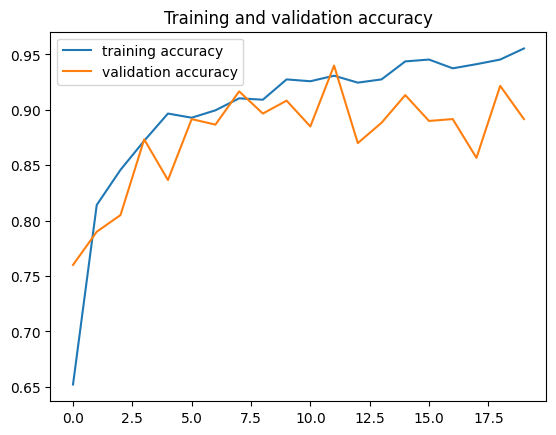

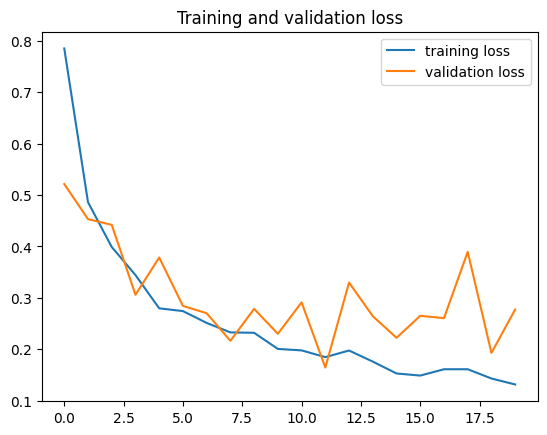

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
from tensorflow.python.saved_model.save import save

save_dir = os.path.join('/tmp/', 'my_model/saved_model.h5')
model.save(save_dir)

In [ ]:
!cd /tmp/my_model/
!tensorflowjs_converter --input_format=keras --output_format=tfjs_layers_model /tmp/my_model/saved_model.h5 /tmp/tfjs_my_model

2023-05-26 16:24:48.875768: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
!zip -r /tmp/tfjs_my_model/modeldata.zip /tmp/tfjs_my_model

  adding: tmp/tfjs_my_model/ (stored 0%)
  adding: tmp/tfjs_my_model/model.json (deflated 96%)
  adding: tmp/tfjs_my_model/group1-shard1of14.bin (deflated 7%)
  adding: tmp/tfjs_my_model/group1-shard7of14.bin (deflated 7%)
  adding: tmp/tfjs_my_model/group1-shard13of14.bin (deflated 7%)
  adding: tmp/tfjs_my_model/group1-shard5of14.bin (deflated 7%)
  adding: tmp/tfjs_my_model/group1-shard14of14.bin (deflated 7%)
  adding: tmp/tfjs_my_model/group1-shard3of14.bin (deflated 7%)
  adding: tmp/tfjs_my_model/group1-shard9of14.bin (deflated 7%)
  adding: tmp/tfjs_my_model/group1-shard2of14.bin (deflated 7%)
  adding: tmp/tfjs_my_model/group1-shard12of14.bin (deflated 7%)
  adding: tmp/tfjs_my_model/group1-shard4of14.bin (deflated 7%)
  adding: tmp/tfjs_my_model/group1-shard10of14.bin (deflated 7%)
  adding: tmp/tfjs_my_model/group1-shard6of14.bin (deflated 7%)
  adding: tmp/tfjs_my_model/group1-shard8of14.bin (deflated 7%)
  adding: tmp/tfjs_my_model/group1-shard11of14.bin (deflated 7%)
